# Exploratory Data Analysis with focus on Biomass Holders

EPFL Students Project for the master course Solid Waste Engineering

**Content:**
This workbook analyses the data of the two litter pickups done by the group and focuses on Moving Bed Biofilm Reactor (MBBR) elements.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re
from scipy.stats import norm
import scipy.stats
import statsmodels.api as sm
import seaborn
import requests
import json
import seaborn as sns
import folium

## 1) Exploratory Data Analysis of All Data on Lake Geneva

#### 1a) Load and prepare data

In [2]:
#read daily totals of all entries at lake Geneva
url = "http://mwshovel.pythonanywhere.com/dirt/daily-total/Lac-Léman/?format=json"
data = requests.get(url).json()
daily_totals = pd.DataFrame(data)

#calculate pieces per meter
daily_totals["pcs_m"]=daily_totals.total / daily_totals.length

#get data for all beaches
codeurl = "http://mwshovel.pythonanywhere.com/dirt/codes/Lac-Léman/?format=json"
data = requests.get(codeurl).json()
codes = pd.DataFrame(data)

#get list of collected objects for tigerduck beach
urlTiger = "http://mwshovel.pythonanywhere.com/dirt/codes/Tiger-duck-beach/?format=json"
tiger = pd.DataFrame(requests.get(urlTiger).json())

#get list of collected objects for Saint Sulpice beach
urlSulp = "http://mwshovel.pythonanywhere.com/dirt/codes/Saint-Sulpice/?format=json"
sulpice = pd.DataFrame(requests.get(urlSulp).json())

#### 1b) Statistics of Pieces/m

Tiger duck beach: 146    77.055556
Name: pcs_m, dtype: float64
Saint Sulpice 147    8.166667
Name: pcs_m, dtype: float64


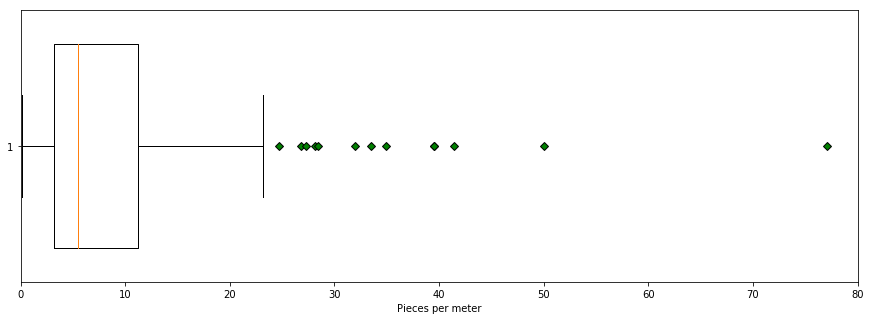

Describing Statistics:


,length,total,pcs_m
count,148.000000,148.000000,148.000000
mean,46.506757,345.398649,9.160844
std,25.013873,364.444349,10.752655
min,7.000000,5.000000,0.117647
25%,27.000000,114.000000,3.183535
50%,51.000000,232.500000,5.526347
75%,61.000000,418.250000,11.240594
max,163.000000,2028.000000,77.055556


In [3]:
# get only tigerduck entry
print('Tiger duck beach:', daily_totals.loc[daily_totals.location == 'Tiger-duck-beach', 'pcs_m'])
print('Saint Sulpice', daily_totals.loc[daily_totals.location == 'Saint-Sulpice', 'pcs_m'])


#boxplot of all litter densities
plt.figure(figsize=(15, 5))
plt.axis([0, 80, 0, 20])
plt.boxplot(daily_totals['pcs_m'], vert=False, widths=0.75, flierprops=dict(markerfacecolor='g', marker='D'))
plt.xlabel('Pieces per meter')
plt.savefig('statistics_all.png')
plt.show()


print('Describing Statistics:')
daily_totals.describe()

**Observation**: Our first colleciton is the maximum point and considered as clear outlier in this dataset. The second observation lies within the 50% Quantile

#### 1c) Compare relative distribution of composition of overall with our beaches

In [5]:
#calculate percentages for overall, tigerduck and sulpice:
codes_cat = codes.groupby(codes.code_id).sum().drop(columns=['length'])
codes_per = codes_cat/codes_cat.sum()
codes_per.columns = ['All Beaches']

tiger_cat = tiger.groupby(tiger.code_id).sum().drop(columns=['length'])
tiger_perc = tiger_cat/tiger_cat.sum()
tiger_perc.columns = ['Plage de Dorigny']

sul_cat = sulpice.groupby(sulpice.code_id).sum().drop(columns=['length'])
sul_perc = sul_cat/sul_cat.sum()
sul_perc.columns = ['Saint-Sulpice']

#merge to one dataframe
p= pd.merge(codes_per,tiger_perc, left_index=True, right_index=True, how='outer')
percentages= pd.merge(p,sul_perc, left_index=True, right_index=True, how='outer')

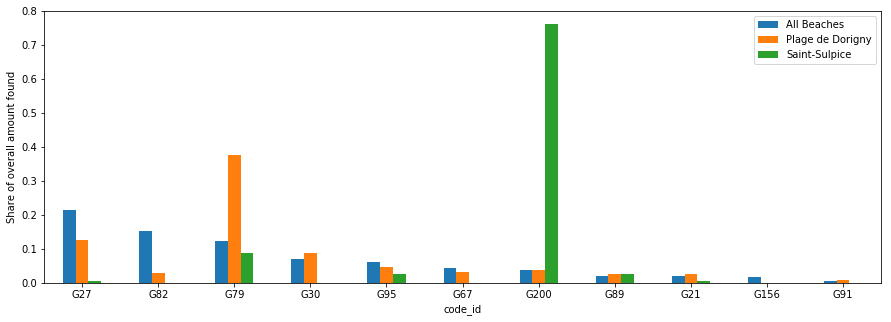

In [6]:
#only get top10 of overall + mbbr
b11 = ['G27','G82', 'G79', 'G30', 'G95', 'G67', 'G200', 'G89', 'G21', 'G156', 'G91']
perctop = percentages[percentages.index.isin(b11)]
perctop = perctop.sort_values(by=['All Beaches'], ascending=False)

#plot barplot
perctop.plot.bar(rot=0,figsize=(15, 5))
plt.ylabel('Share of overall amount found')
plt.show()

## 2) Moving Bed Biofilm Reactor (MBBR) Elements

The mlw code of biomass holder is *G91*
#### 2a) Load and Prepare Data, export for visualization in QGIS

In [7]:
#load plastic codes
csvUrl = "https://mwshovel.pythonanywhere.com/static/newCriteria.csv"
mlwcodes = pd.read_csv(csvUrl, index_col= 'code')

#load location of beaches
beachUrl = "http://mwshovel.pythonanywhere.com/dirt/beaches/Lac-L%C3%A9man/"
beaches = pd.DataFrame(requests.get(beachUrl).json())

#load all inventories of lake Geneva
codeUrl = "https://mwshovel.pythonanywhere.com/dirt/codes/Lac-Léman/"
inventory = pd.DataFrame(requests.get(codeUrl).json()).drop(columns = ['owner', 'project_id'])

#get only entries for G91 and calculate mbbr per meter
mbbr = inventory[inventory['code_id']== 'G91'].copy()
mbbr['density']=mbbr['quantity']/mbbr['length']

In [8]:
# check how on how many beaches G91 has been found
codes[codes['code_id'] == 'G91'].nunique()

#compare to number of number of different beaches in total
codes.nunique()

code_id        121
date           121
length          35
location_id     31
owner            2
project_id       4
quantity       166
dtype: int64

**Obeservation:** On 28 beaches out of 31 beaches in total, biomass holders have been found.

In [9]:
#join to get location information
mbbr_places = mbbr.merge(beaches, left_on='location_id', right_on='location', how='left')

In [10]:
#export data for visualization in QGIS
mbbr_export = mbbr_places.filter(['latitude','longitude','density'], axis=1)
mbbr_export.to_csv('mbbr', index = False)

A map that visualize the location and its quantity has been done by the means of QGIS, as it was faster for us to do so.

#### 2b) Print out distribution of MBBR samples

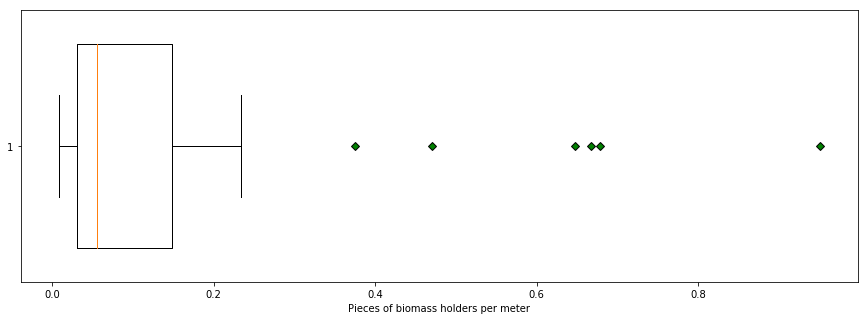

In [11]:
#create boxplot
#boxplot of mbbr densities
plt.figure(figsize=(15, 5))

plt.boxplot(mbbr.density, vert=False, widths=0.75, flierprops=dict(markerfacecolor='g', marker='D'))
plt.xlabel('Pieces of biomass holders per meter')
plt.savefig('statistics_mbbr.png')
plt.show()

#### 2c) Visualization approach (was not used in report..)

In [12]:
#define function for mapping density as circle markers on folium map
import branca

def map_mbbr(data):
    
    # generate a new map with cent
    folium_map = folium.Map(location=[46.409072, 6.486528],
                        zoom_start=10.4,
                        tiles="stamenterrain",
                        width='100%')
    
    colorscale = branca.colormap.linear.YlOrRd_09.scale(0, 50000)
    
    for index, row in data.iterrows():

            radius = row['density']*50
            location = (float(data['latitude'][index]), float(data['longitude'][index]))
            popup_text = "Location: %s , \t Density: %f " % (row['location_id'], row['density'])
            col = colorscale(row['density'])
            
            
            #add marker to map
            folium.CircleMarker(location,
                                color = col,
                                radius=radius,
                                popup=popup_text,
                                fill=False).add_to(folium_map)
    return folium_map
                            

In [13]:
#display & save maps
m= map_mbbr(mbbr_places)
m.save('Mbbr_densities_map')
m

Further analysis ideas:

    -clustering samples in three big clusters: Geneva, Lausanne, Montreux and compare densities